In [1]:
import numpy as np
import pandas as pd
import scipy
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from scipy import spatial

In [2]:
def get_zscore(d):
    return d.subtract(d.mean(axis=1), axis=0).divide(d.std(axis=1), axis=0)

def norm_to_first_column(d):
    d = d.divide(d[d.columns[0]], axis=0)
    return np.log2(d)

tfs = pd.read_csv("/home/chenzonggui/software/SCENIC/allTFs_mm.txt", header=None)[0].values

# Regulatory strategy (all genes)

In [3]:
anno_g = pd.read_csv("../../1_FLAIRseq/results/assembly_custom/gtf_full/MouseBlastocyst.gtf.gene_info.tsv", sep="\t", index_col=1)
anno_g = anno_g[~anno_g.index.duplicated()]
len(anno_g)

55291

In [4]:
cts = ["EPI", "PE", "muralTE", "polarTE"]
array = []
for ct in cts:
    path = "../10_blastocyst/results/halflife/%s.gene_based.gene_id.annotated.tsv" % ct
    m = pd.read_csv(path, sep="\t", index_col=0)
    m = m[~m["GeneName"].isna()]
    m = m[~m["GeneName"].duplicated()]
    m.index = m["GeneName"]
    m.columns = ["%s.%s" % (c, ct) for c in m.columns]
    array.append(m)
m = pd.concat(array, axis=1)

In [5]:
vs = ["GeneName", "GeneType", "Chrom", "Start", "End", "Strand"]
for v in vs:
    for ct in cts:
        del m["%s.%s" % (v, ct)]
for ct in cts:
    del m["Total.Alleles.%s" % ct]
    del m["Nascent.Alleles.%s" % ct]
for ct in cts:
    m["Total.%s" % ct].fillna(0, inplace=True)
    m["Nascent.%s" % ct].fillna(0, inplace=True)
    m["TPM.%s" % ct].fillna(0, inplace=True)
    m["TP10K.%s" % ct].fillna(0, inplace=True)
m = m.merge(anno_g, left_index=True, right_index=True, how="left")

In [6]:
tmp = m[["TPM.%s" % ct for ct in cts]]
m["TPM.Max"] = tmp.max(axis=1)
m["CV"] = tmp.std(axis=1) / tmp.mean(axis=1)

# normalized to the first column
for s in ["K", "D", "TPM"]:
    for ct in cts:
        m["%s.Norm.%s" % (s, ct)] = np.log2(m["%s.%s" % (s, ct)] / m["%s.%s" % (s, cts[0])])

/home/chenzonggui/miniconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwa

In [7]:
tmp = m[["K.Norm.%s" % ct for ct in cts]]
flags1 = np.isfinite(tmp).sum(axis=1) == tmp.shape[1]
tmp = m[["D.Norm.%s" % ct for ct in cts]]
flags2 = np.isfinite(tmp).sum(axis=1) == tmp.shape[1]
tmp = m[["TPM.Norm.%s" % ct for ct in cts]]
flags3 = np.isfinite(tmp).sum(axis=1) == tmp.shape[1]
flags4 = (m["TPM.Max"] > 50) & (m["CV"] > 0.1)
flags = flags1 & flags2 & flags3 & flags4
print(sum(flags))
m0 = m
m = m[flags]

4332


In [8]:
# Similar
tmp1 = m[["K.Norm.%s" % ct for ct in cts]]
tmp2 = m[["D.Norm.%s" % ct for ct in cts]]
similars = []
for vs1, vs2 in zip(tmp1.values, tmp2.values):
    similar = 1 - spatial.distance.cosine(vs1, vs2)
    similars.append(similar)
m["Similar"] = similars

/home/chenzonggui/tmp/ipykernel_5142/2919682135.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m["Similar"] = similars


In [9]:
row_colors = []
for similar in m["Similar"]:
    if similar >= 0.5:
        color = "C2"
    elif similar < -0.5:
        color = "C4"
    else:
        color = "C5"
    row_colors.append(color)
cmap = plt.colormaps["tab20"]
col_colors = [cmap(5), cmap(7), cmap(13), cmap(15)] * 3

row_colors_tf = []
for name in m.index:
    if name in tfs:
        row_colors_tf.append("blue")
    else:
        row_colors_tf.append("red")

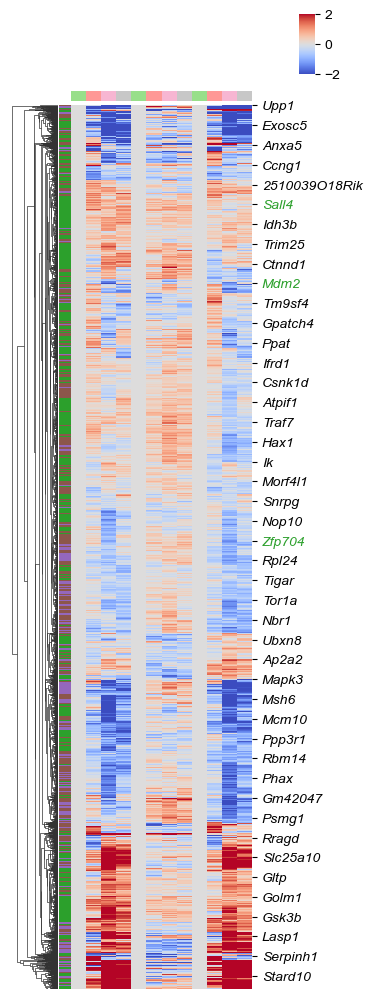

In [10]:
tmp = m[["K.Norm.%s" % ct for ct in cts] + ["D.Norm.%s" % ct for ct in cts] + ["TPM.Norm.%s" % ct for ct in cts]].copy()
tmp.columns = [None] * tmp.shape[1]
ret = sns.clustermap(tmp, col_cluster=False, 
                     row_colors=row_colors, 
                     col_colors=col_colors,
                     dendrogram_ratio=[0.2, 0.07],
                     colors_ratio=[0.05, 0.01],
                     cbar_pos=(0.76, 0.93, 0.04, 0.06),
                     cmap="coolwarm", vmin=-2, vmax=2, figsize=(4, 10))
ret.ax_heatmap.set_xticks([])
ret.ax_heatmap.set_ylabel(None)
for item in ret.ax_heatmap.get_yticklabels():
    if item.get_text() in tfs:
        item.set_color("C2")
    item.set_fontstyle("italic")
# ret.fig.savefig("figures/clustermap_of_regulatory_strategy_gene_based.pdf")

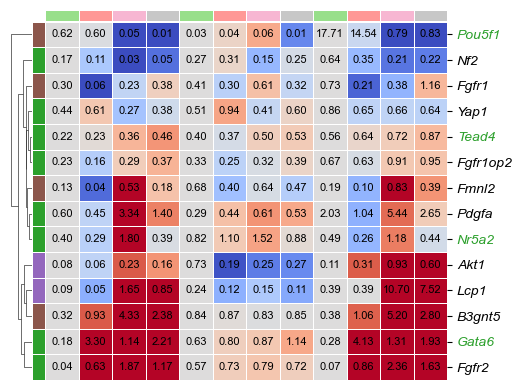

In [211]:
markers = [
    "Gata2", "Gata3", "Rxra", "Tfap2c", "B3gnt5", "Csf3r", "Lcp1", "Fmnl2", "Tead3", "Akt1", "Gata6", "Amot", "Nf2", "Yap1", "Taz", "Tead4", 
    "Sox2", "Nanog", "Cdx2", "Notch1", "Pou5f1", "Gata6", "Bmp4", "Pdgfa", "Sox17", "Sox7", "Gata4", "Pdgfra", "Tfap2c", "Nr5a2"
] + [
    'Fgf1', 'Fgf10', 'Fgf11', 'Fgf12', 'Fgf13', 'Fgf14', 'Fgf15', 'Fgf16', 'Fgf17', 'Fgf18', 'Fgf2', 'Fgf20', 'Fgf21', 'Fgf22', 'Fgf3', 'Fgf4', 
    'Fgf5', 'Fgf6', 'Fgf7', 'Fgf8', 'Fgf9', 'Fgfbp1', 'Fgfbp3', 'Fgfr1', 'Fgfr1op', 'Fgfr1op2', 'Fgfr2', 'Fgfr3', 'Fgfr3-ps', 'Fgfr4', 'Fgfrl1'
]

m_1 = m[m.index.isin(markers)]

row_colors = []
for r in m_1["Similar"]:
    if r >= 0.5:
        color = "C2"
    elif r < -0.5:
        color = "C4"
    else:
        color = "C5"
    row_colors.append(color)

tmp = m_1[["K.Norm.%s" % ct for ct in cts] + ["D.Norm.%s" % ct for ct in cts] + ["TPM.Norm.%s" % ct for ct in cts]].copy()
tmp.columns = [None] * tmp.shape[1]
ret = sns.clustermap(tmp, col_cluster=False, 
                     row_colors=row_colors,
                     col_colors=col_colors,
                     dendrogram_ratio=[0.05, 0.0],
                     colors_ratio=[0.03, 0.03],
                     # cbar_pos=(0.76, 0.93, 0.04, 0.06),
                     cbar_pos=None,
                     lw=0.5,
                     cmap="coolwarm", vmin=-2, vmax=2, figsize=(5.5, 4))
ret.ax_heatmap.set_xticks([])
ret.ax_heatmap.set_ylabel(None)
for item in ret.ax_heatmap.get_yticklabels():
    if item.get_text() in tfs:
        item.set_color("C2")
    item.set_fontstyle("italic")

plt.sca(ret.ax_heatmap)
d_raw_1 = d_raw.loc[ret.data2d.index]
for i in np.arange(d_raw_1.shape[0]):
    for j in np.arange(d_raw_1.shape[1]):
        v = d_raw_1.values[i][j]
        if j >= 8:
            v = v / 100
        plt.text(j + 0.5, i + 0.5, "%.2f" % v, size=8, ha="center", va="center")

# ret.fig.savefig("figures/clustermap_of_markers_gene_based.pdf")

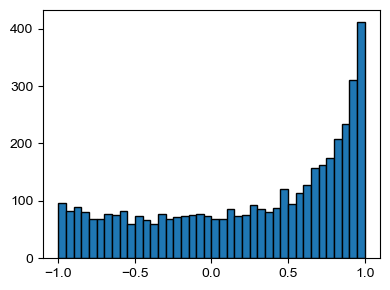

In [51]:
plt.figure(figsize=(4, 3))
plt.hist(m["Similar"], bins=40, edgecolor="black")
plt.tight_layout()
plt.show()

In [53]:
genes1 = m[m["Similar"] >= 0.9].index
genes2 = m[m["Similar"] < -0.8].index
print(len(genes1), len(genes2))
with open("results/genes_high_similar.txt", "w+") as fw:
    for x in genes1:
        fw.write("%s\n" % x)
with open("results/genes_low_similar.txt", "w+") as fw:
    for x in genes2:
        fw.write("%s\n" % x)

723 348


In [95]:
! clusterProfiler_wrapper.sh results/genes_high_similar.txt Mouse results/genes_high_similar.clusterProfiler_outputs
! clusterProfiler_wrapper.sh results/genes_low_similar.txt Mouse results/genes_low_similar.clusterProfiler_outputs

In [54]:
n1 = sum(m["Similar"] > 0.5)
n2 = sum(m["Similar"] < -0.5)
n3 = len(m) - n1 - n2
print("Similar > 0.5:", n1)
print("Similar < -0.5:", n2)
print("-0.5 <= Similar <= 0.5:", n3)

Similar > 0.5: 1995
Similar < -0.5: 781
-0.5 <= Similar <= 0.5: 1556


In [81]:
from collections import defaultdict

with open("/home/chenzonggui/data/go_term/go.obo") as f:
    items = []
    item = None
    for line in f:
        line = line.strip()
        if line == "[Term]":
            item = defaultdict(list)
        elif line == "":
            if item is not None:
                items.append(item)
                item = None
        else:
            if item is not None:
                i = line.find(":")
                assert i != -1
                k = line[:i]
                v = line[i+2:]
                item[k].append(v)

data = dict()
for item in items:
    assert len(item["id"]) == 1
    data[item["id"][0]] = item

networks = defaultdict(list)
for item in items:
    id1 = item["id"][0]
    for x in item["is_a"]:
        id2 = x.split()[0]
        networks[id2].append(id1)

import gzip
tid2genes = defaultdict(set)
with gzip.open("/home/chenzonggui/data/go_term/mgi.gaf.gz", "rt") as f:
    for line in f:
        line = line.strip()
        if line.startswith("!"):
            continue
        row = line.split("\t")
        gene, tid = row[2], row[4]
        tid2genes[tid].add(gene)

def get_genes(tid, tid2genes, networks):
    genes = set()
    for g in tid2genes[tid]:
        genes.add(g)
    for tid2 in networks[tid]:
        for g in get_genes(tid2, tid2genes, networks):
            genes.add(g)
    return genes
genes = get_genes("GO:0005576", tid2genes, networks)

In [126]:
genes = set(m.index)
tid2genes_all = dict()
tid2genes_overlap = dict()
tid2similars = dict()
for tid in data:
    tid2genes_all[tid] = get_genes(tid, tid2genes, networks)
    tid2genes_overlap[tid] = tid2genes_all[tid] & genes
    tid2similars[tid] = np.array(m.loc[list(tid2genes_overlap[tid])]["Similar"])

In [136]:
rows = []
for tid in data:
    name = data[tid]["name"][0]
    genes1 = tid2genes_all[tid]
    genes2 = tid2genes_overlap[tid]
    similars = tid2similars[tid]
    n1 = sum(similars > 0.5)
    n2 = sum(similars < -0.5)
    row = [tid, name, len(genes1), len(genes2), n1, n2]
    rows.append(row)

df = pd.DataFrame(rows)
df.columns = ["GOID", "Name", "Genes", "OverlapGenes", "Destabilizing", "Cooperative"]
df["DestabilizingRatio"] = df["Destabilizing"] / df["OverlapGenes"]
df["CooperativeRatio"] = df["Cooperative"] / df["OverlapGenes"]
df = df.sort_values(by="OverlapGenes")
df = df[df["OverlapGenes"] >= 100]

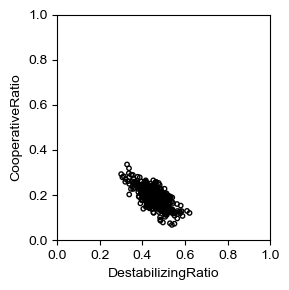

In [147]:
plt.figure(figsize=(3, 3))
plt.scatter(df["DestabilizingRatio"], df["CooperativeRatio"], edgecolor="black", color="none", s=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("DestabilizingRatio")
plt.ylabel("CooperativeRatio")
plt.tight_layout()
plt.show()

In [ ]:
adata = ad.read_h5ad("../10_blastocyst/results/scanpy_processed_gene_based.h5ad")

In [209]:
d_all = sc.get.rank_genes_groups_df(adata, group=None)
d_all = d_all.sort_values(by="pvals_adj")
d_all = d_all[(d_all["pvals_adj"] < 0.001) & (d_all["logfoldchanges"] >= 2)]
d_all = d_all[~d_all["names"].duplicated()]
print(len(d_all))

641


289


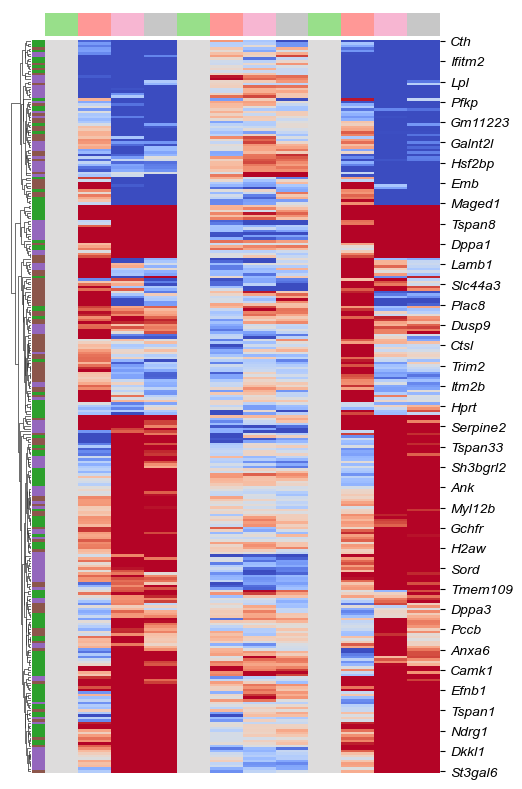

In [210]:
m_1 = m[m.index.isin(d_all["names"])]
print(len(m_1))

row_colors = []
for r in m_1["Similar"]:
    if r >= 0.5:
        color = "C2"
    elif r < -0.5:
        color = "C4"
    else:
        color = "C5"
    row_colors.append(color)

tmp = m_1[["K.Norm.%s" % ct for ct in cts] + ["D.Norm.%s" % ct for ct in cts] + ["TPM.Norm.%s" % ct for ct in cts]].copy()
tmp.columns = [None] * tmp.shape[1]
ret = sns.clustermap(tmp, col_cluster=False, 
                     row_colors=row_colors,
                     col_colors=col_colors,
                     dendrogram_ratio=[0.05, 0.0],
                     colors_ratio=[0.03, 0.03],
                     # cbar_pos=(0.76, 0.93, 0.04, 0.06),
                     cbar_pos=None,
                     # lw=0.5,
                     cmap="coolwarm", vmin=-2, vmax=2, figsize=(5.5, 8))
ret.ax_heatmap.set_xticks([])
ret.ax_heatmap.set_ylabel(None)
for item in ret.ax_heatmap.get_yticklabels():
    if item.get_text() in tfs:
        item.set_color("C2")
    item.set_fontstyle("italic")

plt.sca(ret.ax_heatmap)
d_raw_1 = d_raw.loc[ret.data2d.index]
for i in np.arange(d_raw_1.shape[0]):
    for j in np.arange(d_raw_1.shape[1]):
        v = d_raw_1.values[i][j]
        # plt.text(j + 0.5, i + 0.5, "%.2f" % v, size=8, ha="center", va="center")

# ret.fig.savefig("figures/clustermap_of_markers_gene_based.pdf")

In [202]:
m_1

,Total.EPI,Nascent.EPI,TPM.EPI,TP10K.EPI,NTR.EPI,T.EPI,K.EPI,D.EPI,Total.PE,Nascent.PE,...,K.Norm.polarTE,D.Norm.EPI,D.Norm.PE,D.Norm.muralTE,D.Norm.polarTE,TPM.Norm.EPI,TPM.Norm.PE,TPM.Norm.muralTE,TPM.Norm.polarTE,Similar
GeneName,,,,,,,,,,,,,,,,,,,,,
Septin1,780.0,188.0,468.108601,4.681086,0.241026,7.540020,0.430328,0.091929,17.0,5.0,...,-3.477700,0.0,0.336802,1.412164,1.329606,0.0,-4.830672,-3.942854,-4.807305,-0.793035
Gm2a,74.0,25.0,44.410303,0.444103,0.337838,5.044191,0.061026,0.137415,38.0,4.0,...,3.471058,0.0,-1.890012,-1.875255,-1.213591,0.0,-0.272330,6.169268,4.684649,-0.471335
Myo18a,31.0,19.0,18.604316,0.186043,0.612903,2.191006,0.058857,0.316360,27.0,7.0,...,2.010954,0.0,-1.661065,1.260374,1.035843,0.0,0.489887,2.153886,0.975112,0.866074
Timp1,258.0,92.0,154.835922,1.548359,0.356589,4.715589,0.227594,0.146991,327.0,70.0,...,-3.309316,0.0,-0.872347,-0.306077,1.316924,0.0,1.031115,-3.668679,-4.626240,-0.393956
Ramp2,39.0,16.0,23.405430,0.234054,0.410256,3.937833,0.041199,0.176022,193.0,99.0,...,-1.281559,0.0,0.446063,0.550101,-0.381144,0.0,2.996251,-0.564343,-0.900415,0.682451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Myl6,1161.0,225.0,696.761649,6.967616,0.193798,9.652897,0.500325,0.071807,912.0,202.0,...,2.122104,0.0,0.216928,0.017457,-0.061394,0.0,0.340934,2.559712,2.183499,0.046670
Galnt2l,64.0,22.0,38.408911,0.384089,0.343750,4.936788,0.053928,0.140404,103.0,29.0,...,-1.294592,0.0,-0.349186,1.718610,0.204943,0.0,1.375696,-2.979380,-1.499535,-0.760461
Rhox5,30.0,20.0,18.004177,0.180042,0.666667,1.892789,0.065932,0.366204,667.0,544.0,...,3.921765,0.0,0.621858,0.686160,0.561025,0.0,5.163848,2.471281,3.360740,0.959119


# marker genes

In [3]:
ct1, ct2 = "PE", "EPI"
cts = [ct1, ct2]
array = []
for ct in cts:
    path = "../08_blastocyst/results/halflife/%s_genes.gene_name.tsv" % ct
    m = pd.read_csv(path, sep="\t", index_col=0)
    m.columns = ["%s.%s" % (c, ct) for c in m.columns]
    array.append(m)

In [4]:
m = pd.concat(array, axis=1)
# tmp = m[["TPM.%s" % ct for ct in cts]].fillna(0)
# tmp = tmp[(tmp.min(axis=1) > 300) & ((tmp.std(axis=1) / tmp.mean(axis=1)) > 0.2)]
# m = m.loc[tmp.index]
print(len(m))

20688


In [34]:
# m1 = m[["TPM.%s" % ct1, "TPM.%s" % ct2]].copy()
m1 = m.copy()
m1["TPM.Total.%s" % ct1] = m["TPM.%s" % ct1]
m1["TPM.Total.%s" % ct2] = m["TPM.%s" % ct2]
m1["TPM.Nascent.%s" % ct1] = m["TPM.%s" % ct1] * m["NTR.%s" % ct1]
m1["TPM.Nascent.%s" % ct2] = m["TPM.%s" % ct2] * m["NTR.%s" % ct2]
m1["TPM.Exists.%s" % ct1] = m["TPM.%s" % ct1] * (1 - m["NTR.%s" % ct1])
m1["TPM.Exists.%s" % ct2] = m["TPM.%s" % ct2] * (1 - m["NTR.%s" % ct2])
m1 = m1.fillna(0)
# m1 = m1[m1[["TPM.Total.EPI", "TPM.Total.PE"]].max(axis=1) > 50]
m1 = m1[m1[["TPM.Total.%s" % ct1, "TPM.Total.%s" % ct2]].min(axis=1) > 100]
print(len(m1))

1601


In [35]:
m1["Log2FC.Total"] = np.log2(m1["TPM.Total.%s" % ct2] / m1["TPM.Total.%s" % ct1])
m1["Log2FC.Nascent"] = np.log2(m1["TPM.Nascent.%s" % ct2] / m1["TPM.Nascent.%s" % ct1])
m1["Log2FC.Exists"] = np.log2(m1["TPM.Exists.%s" % ct2] / m1["TPM.Exists.%s" % ct1])
m1 = m1[np.isfinite(m1["Log2FC.Exists"]) & np.isfinite(m1["Log2FC.Nascent"])]

LinregressResult(slope=0.20858871634158394, intercept=-0.0981395865759818, rvalue=0.27570310948538507, pvalue=2.549317139002879e-29, stderr=0.01818687294244513, intercept_stderr=0.010138362980065662)


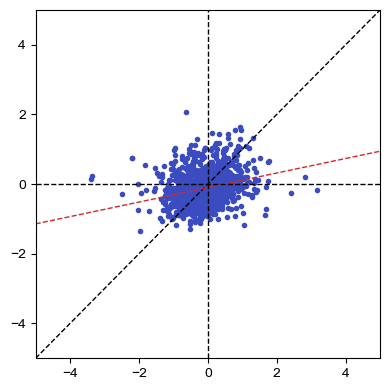

In [67]:
xs = m1["Log2FC.Nascent"]
ys = m1["Log2FC.Exists"]

xs = np.log2(m1["D.%s" % ct2] / m1["D.%s" % ct1])
ys = np.log2(m1["K.%s" % ct2] / m1["K.%s" % ct1])
xs, ys = ys, xs

lim = 5
ret = scipy.stats.linregress(xs, ys)
slope, intercept = ret[:2]
print(ret)
plt.figure(figsize=(4, 4))
plt.scatter(xs, ys, marker=".", color=matplotlib.colormaps["coolwarm"](0))
# sns.kdeplot(x=xs, y=ys, fill=True, cmap="coolwarm")
plt.plot([-lim, lim], [-lim, lim], lw=1, ls="--", color="black")
xs1 = np.linspace(-lim, lim, 1000)
ys1 = [x * slope + intercept for x in xs1]
plt.plot(xs1, ys1, lw=1, ls="--", color="C3")
plt.axvline(0, lw=1, ls="--", color="black")
plt.axhline(0, lw=1, ls="--", color="black")
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.tight_layout()
plt.show()

In [37]:
adata = ad.read_h5ad("../08_blastocyst/results/gene_based.h5ad")
df = sc.get.rank_genes_groups_df(adata, group=None)

In [38]:
df1 = df[(df["group"] == "EPI") & (df["pvals_adj"] < 0.01)]
df1 

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,EPI,Apoe,28.794298,3.324358,2.528206e-182,7.279717e-178
1,EPI,Fn1,27.354452,3.284479,9.559441e-165,1.376273e-160
2,EPI,Mylpf,26.559349,2.750695,2.002929e-155,1.441809e-151
3,EPI,Tdh,25.317175,3.212343,2.066743e-141,9.918301e-138
4,EPI,Septin1,24.672359,4.417889,2.118310e-134,7.624326e-131
...,...,...,...,...,...,...
28789,EPI,Acadl,-23.489349,-3.316567,5.240859e-122,1.160810e-118
28790,EPI,Sdc4,-23.506903,-3.355128,3.466930e-122,8.318899e-119
28791,EPI,Calcoco2,-25.068935,-3.655044,1.085404e-138,4.464733e-135
28792,EPI,Crxos,-25.907057,-3.530795,5.545713e-148,3.193665e-144
